# 3. CNN from scratch with Image Augmentation

Idea: Let’s improve upon our regularized CNN model by adding in more data using a proper image augmentation strategy. Since our previous model was trained on the same small sample of data points each time, it wasn’t able to generalize and predict different classes. The idea behind image augmentation is that we follow a set process of taking in existing images from our training dataset and applying some image transformation operations to them, such as rotation, shearing, translation, zooming, and so on, to produce new, altered versions of existing images. Due to these random transformations, we don’t get the same images each time, and we will leverage Python generators to feed in these new images to our model during training.

Apply image augmentation only on the training images

https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

In [1]:
import os,shutil,math,scipy,cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import pandas as pd
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [2]:
def redo_kreas_category(arr):
    redo=[]
    for i in arr:
        redo.append(list(i).index(1))
    return redo

- Get Data

In here we decided to lower the number of classes we have, to make it easily computable. So we are taking the first 60 categories that have the highest number of pictures.

In [3]:
lists=pd.read_csv('categories.csv')
lists=list(lists['0'])
len(lists)

60

In [4]:
true_labels = []
imgsize=100
#result_array = np.zeros((20580, imgsize, imgsize, 3))
result_array = np.zeros((11386, imgsize, imgsize, 3))
cur_dir = os.path.dirname(os.path.realpath(os.getcwd()))
paths=cur_dir+'/Project/Images/'
# we have 20580 images


j=0
for i in lists:
    images=os.listdir(paths+i)
    label=i[10:]
    for k in images:
        img = cv2.imread(paths+i+'/'+k,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(imgsize,imgsize))
        true_labels.append(label)
        result_array[j,:,:,:]=np.array(img)
        j=j+1

In [5]:
result_array.shape

(11386, 100, 100, 3)

In [6]:
len(true_labels)

11386

In [7]:
len(np.unique(np.array(true_labels)))

60

- Scaling & image augmentation

Each image is of size 224 x 224 and has three channels for red, green, and blue (RGB), hence giving each image the (100, 100, 3) dimensions. We will now scale each image with pixel values between (0, 255) to values between (0, 1) because deep learning models work really well with small input values.


In [8]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

- Train test split & encode y labels

In [9]:
le = LabelEncoder()
le.fit(true_labels)
all_labels_enc = le.transform(true_labels)
all_labels_enc = to_categorical(all_labels_enc,len(np.array(np.unique(true_labels))))

print(true_labels[0:10], all_labels_enc[0:10])

['Maltese_dog', 'Maltese_dog', 'Maltese_dog', 'Maltese_dog', 'Maltese_dog', 'Maltese_dog', 'Maltese_dog', 'Maltese_dog', 'Maltese_dog', 'Maltese_dog'] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0

In [10]:
X = result_array

X_train, X_test, y_train, y_test = train_test_split(X,all_labels_enc,test_size=0.2,random_state=69)
X_train, X_val, y_train, y_val  = train_test_split(X_train,y_train,test_size=0.2,random_state=69)

In [11]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=30)
val_generator = val_datagen.flow(X_val, y_val, batch_size=20)

- Modeling

In [16]:
#batch_size = 30 #number of images passed to the operation in every iteration
#num_classes = len(np.array(np.unique(true_labels))) # target class
epochs = 100  #30 #number of times the entire dataset has gone through the neural network
input_shape = (imgsize, imgsize, 3)

In [13]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(np.array(np.unique(true_labels))), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxP

In [17]:
# so i am basically in each epoch, i am training on 100*30 = 3000 randomly generated images from true images
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=epochs,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1)              


Epoch 1/100
100/100 [==============================] - 45s 449ms/step - loss: 4.0942 - acc: 0.0177 - val_loss: 4.0902 - val_acc: 0.0244
Epoch 2/100
100/100 [==============================] - 45s 446ms/step - loss: 4.0895 - acc: 0.0250 - val_loss: 4.0821 - val_acc: 0.0200
Epoch 3/100
100/100 [==============================] - 45s 446ms/step - loss: 4.0751 - acc: 0.0213 - val_loss: 4.0469 - val_acc: 0.0377
Epoch 4/100
100/100 [==============================] - 45s 449ms/step - loss: 4.0409 - acc: 0.0390 - val_loss: 3.9990 - val_acc: 0.0470
Epoch 5/100
100/100 [==============================] - 45s 445ms/step - loss: 4.0239 - acc: 0.0400 - val_loss: 3.9879 - val_acc: 0.0346
Epoch 6/100
100/100 [==============================] - 45s 448ms/step - loss: 3.9960 - acc: 0.0397 - val_loss: 3.9047 - val_acc: 0.0690
Epoch 7/100
100/100 [==============================] - 45s 445ms/step - loss: 3.9615 - acc: 0.0458 - val_loss: 3.8963 - val_acc: 0.0560
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 44s 445ms/step - loss: 3.4579 - acc: 0.1157 - val_loss: 3.4046 - val_acc: 0.1550
Epoch 62/100
100/100 [==============================] - 44s 444ms/step - loss: 3.4725 - acc: 0.1171 - val_loss: 3.4176 - val_acc: 0.1395
Epoch 63/100
100/100 [==============================] - 45s 446ms/step - loss: 3.4263 - acc: 0.1227 - val_loss: 3.2692 - val_acc: 0.1640
Epoch 64/100
100/100 [==============================] - 45s 449ms/step - loss: 3.4617 - acc: 0.1160 - val_loss: 3.2795 - val_acc: 0.1558
Epoch 65/100
100/100 [==============================] - 45s 450ms/step - loss: 3.4711 - acc: 0.1218 - val_loss: 3.3526 - val_acc: 0.1760
Epoch 66/100
100/100 [==============================] - 45s 452ms/step - loss: 3.4259 - acc: 0.1227 - val_loss: 3.4302 - val_acc: 0.1375
Epoch 67/100
100/100 [==============================] - 45s 446ms/step - loss: 3.4315 - acc: 0.1248 - val_loss: 3.4226 - val_acc: 0.1558
Epoch 68/100
100/100 [===================

In [18]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [25]:
history.history['acc']

[0.01766666755080223,
 0.02503337906810327,
 0.021333334408700465,
 0.03905207101499366,
 0.040000001713633535,
 0.039666668251156806,
 0.045727638589922036,
 0.04333333507180214,
 0.05106809281698056,
 0.04833333529531956,
 0.05607476864552227,
 0.04766666874289513,
 0.05266666881740093,
 0.04639519570775837,
 0.056000002063810825,
 0.05740988230176061,
 0.05800000235438347,
 0.05600000225007534,
 0.06341789300753692,
 0.07200000286102295,
 0.06642189823856978,
 0.06733333609998227,
 0.06133333578705788,
 0.07142857395022988,
 0.07666666969656945,
 0.06975968211929057,
 0.06966666899621486,
 0.0804405904789076,
 0.08100000284612179,
 0.07700000278651714,
 0.0754339145807343,
 0.0843333363160491,
 0.08110814714413857,
 0.08866666983813047,
 0.08366666931658984,
 0.0944592823039427,
 0.08666666973382235,
 0.09012016322518461,
 0.08766666986048222,
 0.09133333630859852,
 0.09779706608767662,
 0.10566667031496763,
 0.10747663920698003,
 0.09066666983067989,
 0.09846462309360504,
 0.100000

- See accuracy in test dataset & double check other accuracies

In [24]:
1+1

2

In [20]:
# test
y_test_model = model.predict_classes(X_test)
y_test_model_prob=model.predict_proba(X_test)
print(y_test_model_prob.shape)
y_test_true_flat=redo_kreas_category(y_test)
print(np.unique(y_test_model))
print(accuracy_score(y_test_model, y_test_true_flat))

(2278, 60)
[ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 24 26 27 28
 29 30 32 33 34 35 36 37 38 39 40 41 43 44 45 46 47 48 49 50 51 52 53 54
 55 57 58 59]
0.10316066725197541


In [21]:
# validation
y_val_model = model.predict_classes(X_val)
y_val_model_prob=model.predict_proba(X_val)
print(y_val_model_prob.shape)
y_val_true_flat=redo_kreas_category(y_val)
print(np.unique(y_val_model))
print(accuracy_score(y_val_model, y_val_true_flat))

(1822, 60)
[ 0  1  2  4  5  6  7  8  9 10 11 13 15 16 19 20 24 26 27 28 29 30 32 33
 34 35 37 38 39 41 44 45 46 47 48 49 50 52 53 54 55 56 57 58 59]
0.09879253567508232


In [22]:
# train
y_train_model = model.predict_classes(X_train)
y_train_model_prob=model.predict_proba(X_train)
print(y_train_model_prob.shape)
y_train_true_flat=redo_kreas_category(y_train)
print(np.unique(y_train_model))
print(accuracy_score(y_train_model, y_train_true_flat))

(7286, 60)
[ 0  1  2  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 41 42 43 44 45 46 47 48 49 50 52
 53 54 55 56 57 58 59]
0.10389788635739775


- Graphs

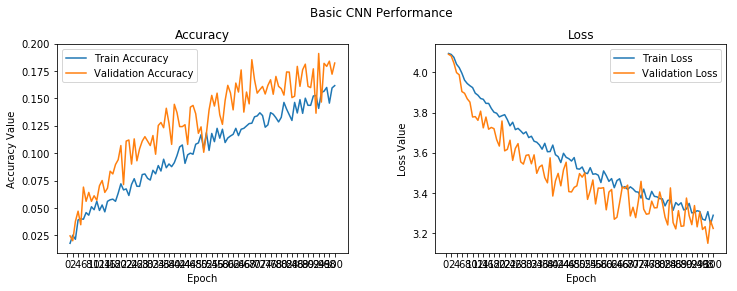

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,len(history.history['acc'])+1))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 2))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 2))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")